In [1]:
import torch
import numpy as np
import datasets
import os
import umap
import evaluate
import accelerate
import random
from pathlib import Path
from itertools import product
from IPython.core.debugger import set_trace
from datasets import Dataset, DatasetDict
from torch import nn
from torch.nn import functional as F
from sentence_transformers import SentenceTransformer
from nltk import sent_tokenize
from IPython.core.debugger import Pdb
from matplotlib import pyplot as plt
from transformers import AutoModel, AutoTokenizer
from pprint import pprint
from scipy.stats import spearmanr
from tqdm import tqdm
from multiprocessing import Pool
from itertools import chain
from numpy.lib.stride_tricks import sliding_window_view
from langchain_community.llms import VLLM

from nbtools.sent_encoders.hf_models import from_hf
from nbtools.utils import (
    files,
    tensor_utils,
    display,
)

cache_dir = f'{files.project_root()}/cache'
data_dir = f'{files.project_root()}/data'
display.note(f'cache_dir set to \'{cache_dir}\'')
display.note(f'data set to \'{data_dir}\'')

datasets.disable_caching()

# Set this to whatever you want
seed = 10

torch.manual_seed(seed)
np.random.seed(seed)

%load_ext autoreload
%autoreload 2
%matplotlib inline


KeyboardInterrupt: 

# Load a Dataset

In [2]:
ds = datasets.load_dataset(
    'cnn_dailymail',
    '1.0.0',
    cache_dir=cache_dir,
    trust_remote_code=True,
)

print(ds)

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})


# Get Sentence Counts for Test Set

avg len: 33.37006092254134
ratio of samples within limit (16): 0.1598
ratio of samples within limit (32): 0.5831
ratio of samples within limit (64): 0.9266
ratio of samples within limit (128): 0.9990
ratio of samples within limit (256): 1.0000


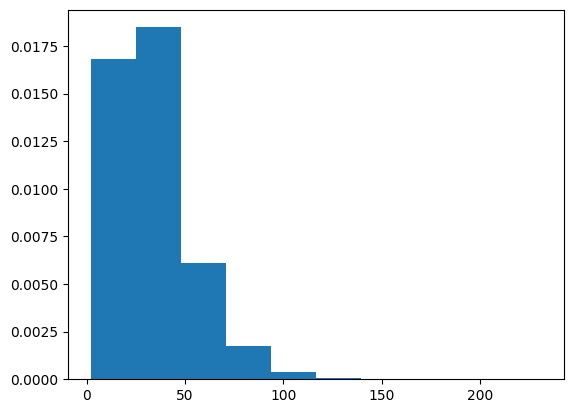

In [3]:
#lengths = np.array([len(sent_tokenize(x['article'])) for x in ds['test']])
num_proc = 10
#data = ds['train'][:]

def map_fn(x):
    return len(sent_tokenize(x['article']))

with Pool(num_proc) as p:
    counts = np.array(list(p.imap(
        map_fn,
        ds['test'],
    )))

#sent_counts = np.load('/data/john/files/wikipedia_sent_counts.npy')
print(f'avg len: {np.mean(counts)}')
_ = plt.hist(counts, bins=100 density=True)

limits = np.array([16, 32, 64, 128, 256])
for limit in limits:
    print(f'ratio of samples within limit ({limit}): {len(counts[counts <= limit])/len(counts):.04f}')


# Load LLM and Make Text Format Function

In [4]:

llm = VLLM(
    model='mistralai/Mistral-7B-Instruct-v0.2',
    tensor_parallel_size=4,
    trust_remote_code=True,  # mandatory for hf models
    download_dir=cache_dir,
    enforce_eager=True,
)

llm.invoke('how many ounces are in a gallon')

2024-04-11 21:53:42,795	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-04-11 21:53:45,610	INFO worker.py:1752 -- Started a local Ray instance.


INFO 04-11 21:53:46 llm_engine.py:74] Initializing an LLM engine (v0.4.0.post1) with config: model='mistralai/Mistral-7B-Instruct-v0.2', tokenizer='mistralai/Mistral-7B-Instruct-v0.2', tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=True, dtype=torch.bfloat16, max_seq_len=32768, download_dir='/data/john/projects/nb/cache', load_format=auto, tensor_parallel_size=4, disable_custom_all_reduce=True, quantization=None, enforce_eager=False, kv_cache_dtype=auto, device_config=cuda, seed=0)
INFO 04-11 21:53:54 selector.py:51] Cannot use FlashAttention because the package is not found. Please install it for better performance.
INFO 04-11 21:53:54 selector.py:25] Using XFormers backend.
(RayWorkerVllm pid=185085) INFO 04-11 21:53:55 selector.py:51] Cannot use FlashAttention because the package is not found. Please install it for better performance.
(RayWorkerVllm pid=185085) INFO 04-11 21:53:55 selector.py:25] Using XFormers backend.
(RayWorkerVllm pid=185085) INFO

Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.76s/it]


'\n\nDoes One Gallon Equal 128 Ounces?\n\nOne gallon is equal to 128 ounces when measuring liquid volume. However, when measuring weight, one gallon of water weighs approximately 8.34 pounds, so 128 ounces would be roughly 8.6 pounds, which is not exactly one gallon in weight.\n\nThe conversion from gallons to ounces is a straightforward one:\n\n1 gallon = 128 ounces\n\nTo better understand this relationship, one quart is equivalent to 32 ounces. There are four quarts in one gallon, so 1 gallon = 4 quarts = 128 ounces.\n\nFAQs:\n\n1. How many pints are in a gallon?\nOne gallon is equal to 160 pints.\n2. How many liters are in a gallon?\nOne gallon is equal to approximately 3.785 liters.\n3. How many cups are in a gallon?\nOne gallon is equal to 128 cups (assuming each cup holds 8 ounces).\n\nConclusion:\n\nWhen measuring liquid volumes, one gallon is indeed equal to 128 ounces. Using this conversion can help make accurate measurements for various recipes or serving sizes. Furthermore, 

# Loop to Pick Sentences to Reconstruct

In [23]:
sent_mask = '<SENTENCE_MASK>'
columns = {
    'target': [],
    'prompt': [],
    'response': [],
}
for sample in tqdm(ds['test']):
    
    # pick a sentence (ignore first and last)
    sents = sent_tokenize(sample['article'])
    try:
        target = random.choice(sents[1:-1])
        new_doc = sample['article'].replace(target, sent_mask)
        prompt = f'<s>[INST]{new_doc}\n\nbased on the article above, output only the predicted missing sentence denoted by "{sent_mask}"[/INST]'
    except:
        target = ''
        new_doc = ''
        prompt = ''

    columns['target'].append(target)
    columns['prompt'].append(prompt)

#responses = llm.invoke(columns['prompt'])
resp_gen = llm.map()
responses = resp_gen.invoke(columns['prompt'])
columns['response'] = responses
print(responses)

out_ds = ds['test']
for column, data in columns.items():
    out_ds = out_ds.add_column(column, data)
out_ds.to_json(f'{data_dir}/infill_data.json')
print(out_ds)


  0%|          | 0/11490 [00:00<?, ?it/s]

Processed prompts: 100%|██████████| 11490/11490 [26:29<00:00,  7.23it/s]


[' The inquiry will include alleged war crimes committed since June 13, 2014, in the Palestinian territories.', " Theia's resilience and determination to survive have inspired many, and donations to her fundraising page have already exceeded the initial $10,000 goal. Mellado is committed to ensuring that Theia receives the necessary medical care and finds a loving home where she will be safe. Any additional funds raised will be used to help other animals in need.", ' Zarif has been the subject of controversy regarding his views on the Holocaust. In September 2013, he tweeted "Happy Rosh Hashanah" in response to which Christine Pelosi, the daughter of House Minority Leader Nancy Pelosi, tweeted "Thanks. The New Year would be even sweeter if you would end Iran\'s Holocaust denial, sir." Zarif responded, "Iran never denied it. The man who was perceived to be denying it is now gone. Happy New Year." This exchange referenced Ahmadinejad, who had left office the previous month, and Zarif was

Creating json from Arrow format: 100%|██████████| 12/12 [00:00<00:00, 16.24ba/s]


102064135

# Evaluate Output Data

In [19]:
infill_data = Dataset.from_json(f'{data_dir}/infill_data.json')
rscorer = evaluate.load('rouge')
bscorer = evaluate.load('bertscore')

scores = rscorer.compute(
    predictions=infill_data['response'],
    references=infill_data['target'],
    use_aggregator=False,
)
bertscore = bscorer.compute(
    predictions=infill_data['response'],
    references=infill_data['target'],
    lang='en',
    verbose=True,
    rescale_with_baseline=True
)
scores['bertscore'] = bertscore['f1']

out_ds = infill_data
for name, data in scores.items():
    out_ds = out_ds.add_column(name, data)

out_ds.add_column(
    'bertscore_hash',
    len(out_ds)*[bertscore['hashcode']]
)

out_ds.to_json(f'{data_dir}/infill_data_evaluated.json')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/357 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/180 [00:00<?, ?it/s]

done in 112085.54 seconds, 0.10 sentences/sec


Creating json from Arrow format:   0%|          | 0/12 [00:00<?, ?ba/s]

103289408

In [20]:
# reload data
infill_data = Dataset.from_json(f'{data_dir}/infill_data_evaluated.json')

Generating train split: 0 examples [00:00, ? examples/s]

# Plot Distribution of ROUGE-1 Scores

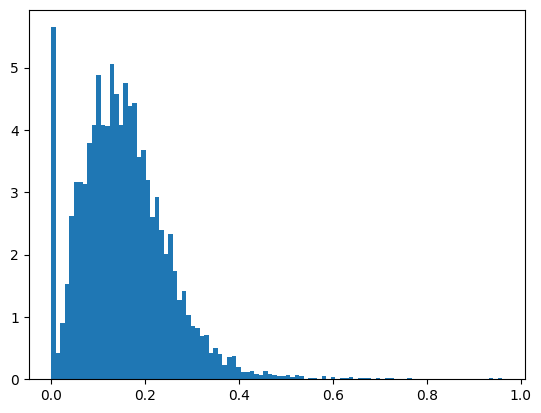

In [16]:

_ = plt.hist(infill_data['rouge1'], bins=100, density=True)

# Plot Distribution of ROUGE-2 scores

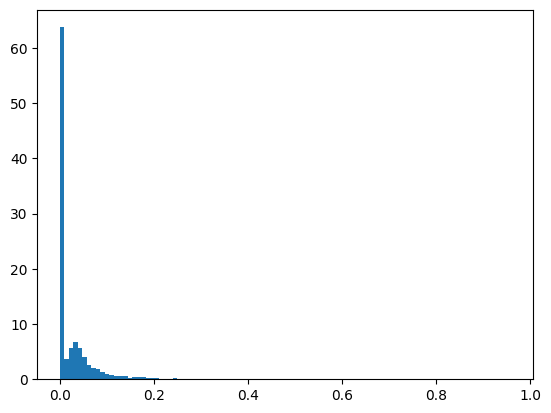

In [17]:
_ = plt.hist(infill_data['rouge2'], bins=100, density=True)

# Plot Distribution of BERTscore Scores

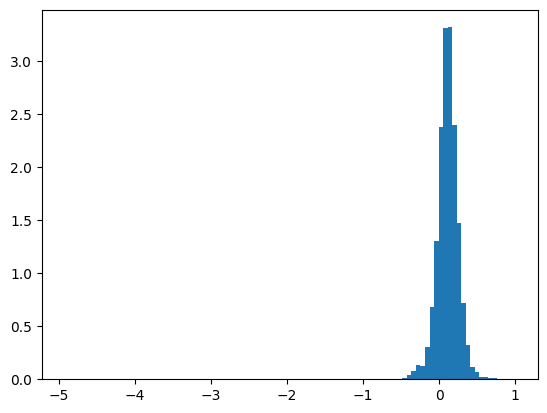

In [21]:
_ = plt.hist(infill_data['bertscore'], bins=100, density=True)

In [22]:
sample = random.choice(infill_data)
pprint(sample)

{'article': 'Looking after elderly parents can be difficult at the best of '
            "times. But this man takes caring for his Alzheimer's-suffering "
            'mother to another level. A security guard from China has touched '
            'hearts across the country because he takes his 84-year-old mother '
            'with him to work on the back of his motorbike every single day, '
            "reported the\xa0People's Daily Online. Lu Xincai, who lives in "
            'Zhejiang province in eastern China, says that he is scared his '
            'mother will get lost if he leaves her at home by herself because '
            'she suffers from the degenerative disease. Devoted: Lu Xincai '
            'takes his 84-year-old mother to work with him on the back of his '
            'motorbike every day. He ties a sash around both of their waists '
            "to make sure she doesn't fall off . She would often go up to the "
            'mountains to collect firewood and there 